# Импорт

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Глобальные константы
* levels_count - количество уровней за 2 итерации
* non_valid_ips - ip адреса, которые должны быть отсечены
* non_valid_hdid - устройства, которые должны быть отсечены для сбора статистики 

In [2]:
levels_count = 21 + 22
non_valid_ips = [
    '178.71.128.254',
    '81.200.120.104',
    '217.66.159.55',
    '92.100.108.227',
    '78.140.203.202',
    '81.200.120.52',
    '217.66.159.130',
    '81.200.120.34',
    '93.185.30.8',
    '146.120.75.64',
    '83.102.203.123',
    '83.102.203.252',
    '188.170.78.68',
    '178.70.231.205',
    ''
]
non_vaild_hdid = [
    '8e5604af-99db-47a5-b5e9-465040486690',
    '392b661b-f6c8-4686-928a-30318a870343',
    'be7125c7-c1a9-44b1-b1e8-f46e27b3b07e',
    'fd85bf04-e899-441d-a2e6-cc26ca7360b7',
    'd6ce40ec-93af-4b85-82f4-bac4860fffa2',
    'be24a7a4-d904-48ad-b08d-f1bb5bd96523',
    '2750bc42-702e-4cbe-bae5-798f171389e1',
    'ca02a2c6-1202-4d45-9a76-3a20f8333a41',
    '781d80dd-810d-42cc-bc98-fccbf16a3e38',
    'd520c7a8-421b-4563-b955-f5abc56b97ec',
     ''
]

# Настройки pandas

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Считывание и фильтрация
* math_game_log.csv - выкаченная полностью таблица с https://mathhelper.space:5432 (25.04.2020)
* math_game_log_2.csv - выкаченная полностью таблица с https://mathhelper.space:5432 (02.05.2020)

In [4]:
math_log = pd.read_csv("math_game_log_2.csv", low_memory=False, dtype={
    "id": int,
    "game": str,
    "action": str,
    "comment": str,
    "device_ts": int,
    "server_ts": int,
    "create_date_time": object,
    "user_game_identifier": str,
    "login": str,
    "name": str,
    "surname": str,
    "second_name": str,
    "group": str,
    "institution": str,
    "age": str,
    "user_mark": float,
    "user_comment": str,
    "total_time_mult_coef": str,
    "total_award_mult_coef": str,
    "ip": str,
    "hardware_device_id": str,
    "hardware_speed_coef": str,
    "hardware_properties": str,
    "task_id": int,
    "task_type": str,
    "total_time_ms": int,
    "difficulty": float,
    "min_steps": int,
    "award_coefs": str,
    "show_wrong_rules": str,
    "show_subst_result": str,
    "undo_considering_policy": str,
    "long_expression_cropping_policy": str,
    "curr_time_ms": int,
    "time_from_last_action_ms": int,
    "curr_steps_number": float,
    "next_steps_number": float,
    "sub_actions_number": int,
    "sub_actions_after_last_transformation": int,
    "left_time_ms": int,
    "left_lives": int,
    "curr_award_coef": float,
    "curr_rule": str,
    "curr_selected_place": str,
    "curr_expression": str,
    "next_expression": str,
    "end_expression_hide": str,
    "expression_size": float
})
math_log.query("ip not in @non_valid_ips and hardware_device_id not in @non_vaild_hdid",
                inplace=True)
math_log.query("game == 'MathGame_IK_an'", inplace=True)

# Сценарии
## Оценки пользователей
Вопрос - пользовались ли студенты оценками и что же они поставили?

~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Stats ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
count    12.000000
mean      4.541667
std       0.782140
min       3.000000
25%       4.375000
50%       5.000000
75%       5.000000
max       5.000000
Name: user_mark, dtype: float64


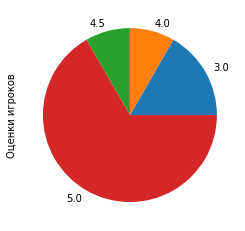

In [5]:
signs: pd.DataFrame = math_log.query("action == 'mark'")
#print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~ All marks ~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#print(signs[["user_game_identifier", "user_mark", "user_comment"]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Stats ~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(signs["user_mark"].describe())
fd: pd.DataFrame = signs.drop(["user_game_identifier", "user_comment"], axis=1)\
    .groupby("user_mark", as_index=False).size()
fd.name = "Оценки игроков"
fd.plot.pie()

## Bug reports
Пользовались ли игроки данной опцией?

In [6]:
reports: pd.DataFrame = math_log.query("action == 'problem'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~ All reports ~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(reports[["user_game_identifier", "user_comment"]])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~ All reports ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                                                         user_game_identifier  \
118667  burkov.ap_Алексей_Бурков_Петрович_363010280004_СПБПУ___MathGame_IK_an   
211459      Neroican_Дмитрий_Анфиногентов__363010280003_ИПММ___MathGame_IK_an   
268667      Neroican_Дмитрий_Анфиногентов__363010280003_ИПММ___MathGame_IK_an   

                                                 user_comment  
118667     Каким-то образом получилось 25.3 шага в 15 уровне.  
211459                 Не отображаются медали за прохождение.  
268667  Прошел 17-ый уровень за 58.5 шагов (баг с подсчетом?)  


## Zoom
Пользовались ли функцией приближения?

Для **user_game_identifier** считаем количество разных размеров центрального выражения.
Далее посчитаем отношение количества строк, где это количество > 1 (размер менялся игроком), к количеству всех строк.
Таким образом, получим сколько процентов игроков пользовались зумом.

In [7]:
zoom: pd.DataFrame = math_log.query("expression_size != 0").copy()
users: pd.DataFrame = zoom[["user_game_identifier", "expression_size", "task_id"]]\
    .groupby(["user_game_identifier", "expression_size"], as_index=False)
grouped: pd.DataFrame = users.size()
zoom_usage: pd.DataFrame = grouped.groupby(["user_game_identifier"]).size().reset_index(name="count")
series_obj = zoom_usage.apply(lambda x: x["count"] > 1, axis=1)
zoom_used = len(series_obj[series_obj == True].index)
print("Zoom usage: %s %%" % (zoom_used / zoom_usage.shape[0] * 100))

Zoom usage: 50.0 %


## Обучает ли игра?
Рассмотрим следующий коэффициент: отношение медианы времени прохождения уровня к минимальному времени его прохождения в квадрате.  
Уменьшение этого коэффициента ближе к концу игры будет говорить об эффективности обучения игры. 

Сначала найдем ценных игроков (пусть это будут игроки, прошедшие 30% от уровней 2 итераций)

In [8]:
value = 0.3
wins: pd.DataFrame = math_log.query("action == 'win'").copy()
winners: pd.DataFrame = wins.groupby(["user_game_identifier", "task_id"]).size().reset_index(name="wins_count")
winners_stat: pd.DataFrame = winners.groupby(["user_game_identifier"]).size().reset_index(name="levels_passed")
valuable_players = winners_stat[winners_stat['levels_passed'] > levels_count * value]
print(valuable_players["user_game_identifier"])
valuable_players_list = valuable_players["user_game_identifier"].tolist()

1                                 100500vik_viktor_gerasimenko_gerasimenko_363010280002_IPMM___MathGame_IK_an
3                                                         Ari_Анастасия_Мальцева__80002_ИПММ___MathGame_IK_an
4                                      ArinaZz_Arina_Zykova_Vyacheslavovna_363010280003_ИПММ___MathGame_IK_an
6                                    Dannikk_Nikita_Danilov_Aleksandrovich_363010280003_IAMM___MathGame_IK_an
7                                     DariaWelt_Daria_Smirnova__1_Applied_Math_and_Mechanic____MathGame_IK_an
8                                                 EvilHonda666_Egor_Mikhaylov__80003_3630102___MathGame_IK_an
9                                        GameD_M_Захар_Саранин_Алексеевич_363010280003_СПбПУ___MathGame_IK_an
10                                                Greta_Tuborg_Arseny_Velichko__3630102_IAMM___MathGame_IK_an
11                                        KhripunkovDV_Дмитрий_Хрипунков__363010280001_СПБПУ___MathGame_IK_an
12    Mekh

Среди эти игроков посмотрим статистику побед.
Посмотрим за какое время (в секундах) в среднем проходился каждый уровень и разобьем на 2 итерации:
1. Уровни с task_id из [100, 120]  
    1.1. В виду ошибки составления уровней, их task_id перемешались, поэтому для восстановления игрового порядка этих уровней необхожимо применить переиндексацию
2. Уровни с task_id из [1000, 1022]  
    2.1. В виду ошибки в 4 правилах на "\" ~> "->" 12, 13, 17 и 18 уровни можно было решить в 3 шага, хотя на самом деле нужно гораздо больше. Для 12 и 13 удалось понять минимальные значения, для 17 и 18 увы нет....

Для первой итерации переиндексируем уровни в соответствии с их порядком в игре.

In [9]:
wins: pd.DataFrame = math_log.query("action == 'win'").copy()
wins.query("user_game_identifier in @valuable_players_list", inplace=True)
levels: pd.DataFrame = wins.groupby(["task_id", "curr_time_ms", "curr_steps_number"]).size().reset_index(name="count")
levels.drop(["count"], axis=1, inplace=True)
levels_median: pd.DataFrame = levels.groupby("task_id", as_index=False).median()
levels_median["curr_time_s"] = levels_median["curr_time_ms"] / 1000
#print(levels_median)

levels_min: pd.DataFrame = levels.groupby("task_id", as_index=False).min()
levels_min["curr_time_s"] = levels_min["curr_time_ms"] / 1000

levels_min.at[32, "curr_time_s"] = 17.0
levels_min.at[32, "curr_steps_number"] = 10.0
levels_min.at[33, "curr_time_s"] = 22.0
levels_min.at[33, "curr_steps_number"] = 9.0

#print(levels_min)

levels_effect = pd.DataFrame()
levels_effect["task_id"] = levels_median["task_id"]
levels_effect["time_coeff"] = levels_median["curr_time_s"] / levels_min["curr_time_s"] ** 2
levels_effect["step_coeff"] = levels_median["curr_steps_number"] / levels_min["curr_steps_number"] ** 2

first_iter_effect: pd.DataFrame = levels_effect[(levels_effect["task_id"] >= 100) & (levels_effect["task_id"] <= 120)].copy()
second_iter_effect: pd.DataFrame = levels_effect[(levels_effect["task_id"] >= 1000) & (levels_effect["task_id"] <= 1022)].copy()
first_iter_effect = first_iter_effect.reindex([0, 1, 4, 5, 6, 7, 11, 12, 13, 20, 18, 3, 9, 8, 10, 14, 16, 2, 17, 15, 19])
second_iter_effect.drop([37, 38], inplace=True)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ First iteration ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(first_iter_effect)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Second iteration ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(second_iter_effect)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ First iteration ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    task_id  time_coeff  step_coeff
0       100    1.242554    1.000000
1       101    0.250463    0.240000
4       104    0.118609    0.166667
5       105    0.087147    0.166667
6       106    0.076969    0.240000
7       107    0.228658    0.333333
11      111    0.254580    0.333333
12      112    0.085347    0.250000
13      113    0.068632    0.333333
20      120    0.216006    0.388889
18      118    0.127615    0.333333
3       103    0.048935    0.240000
9       109    0.094164    0.200000
8       108    0.093179    0.166667
10      110    0.111937    0.312500
14      114    0.042881    0.142857
16      116    0.115214    0.312500
2       102    0.017772    0.132812
17      117    0.046702    0.142857
15      115    0.043993    0.106198
19      119    0.084956    0.194444
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Second iteration ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    task_id  time_coeff  step_c

Рассмотрим общие графики для двух итераций.

Сначала по времени прохождения уровней:

[-0.02059428  0.3911234 ]
[-0.03686837  0.78806494]


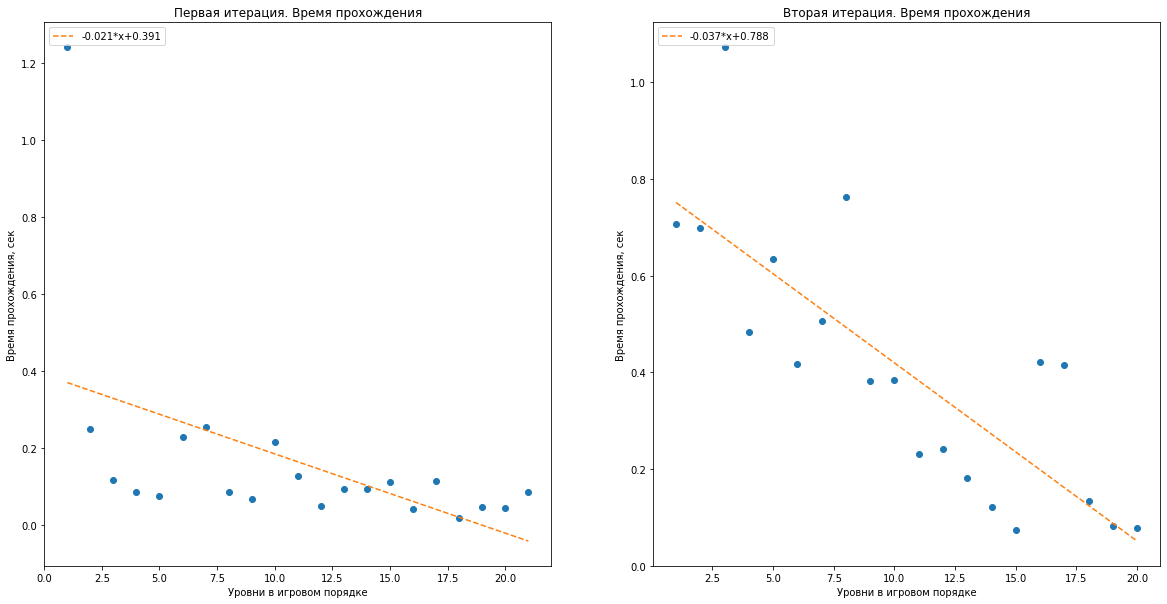

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

plt.title("Первая итерация. Время прохождения")
plt.xlabel("Уровни в игровом порядке")
plt.ylabel("Время прохождения, сек")

x_first = np.asarray(list(range(1, 22)))
y_first = first_iter_effect["time_coeff"].to_numpy()
plt.plot(x_first, y_first, "o")
k1 = np.polyfit(x_first, y_first, 1)
print(k1)
plt.plot(x_first, np.polyval(k1, x_first), "--", label="{:.3f}*x+{:.3f}".format(k1[0], k1[1]))
plt.legend(loc=2)

plt.subplot(1, 2, 2)

plt.title("Вторая итерация. Время прохождения")
plt.xlabel("Уровни в игровом порядке")
plt.ylabel("Время прохождения, сек")

x_second = np.asarray(list(range(1, 21)))
y_second = second_iter_effect["time_coeff"].to_numpy()
plt.plot(x_second, y_second, "o")
k2 = np.polyfit(x_second, y_second, 1)
print(k2)
plt.plot(x_second, np.polyval(k2, x_second), "--", label="{:.3f}*x+{:.3f}".format(k2[0], k2[1]))
plt.legend(loc=2)

Теперь по шагам:

[-0.01422532  0.42964002]
[-0.02149999  0.47598373]


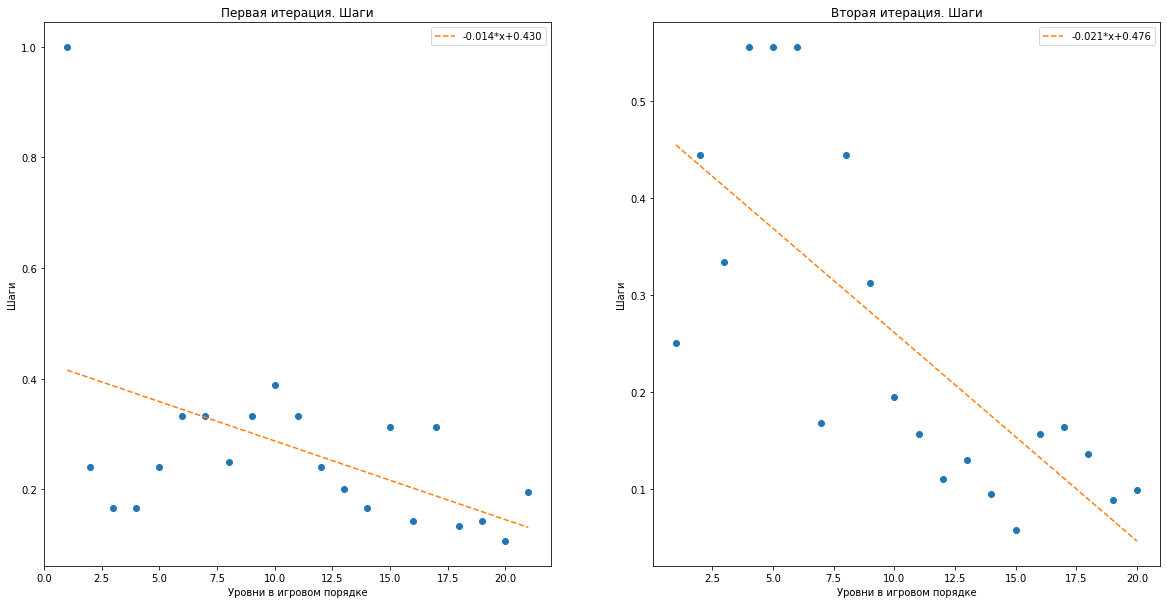

In [11]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

plt.title("Первая итерация. Шаги")
plt.xlabel("Уровни в игровом порядке")
plt.ylabel("Шаги")

x_first = np.asarray(list(range(1, 22)))
y_first = first_iter_effect["step_coeff"].to_numpy()
plt.plot(x_first, y_first, "o")
k1 = np.polyfit(x_first, y_first, 1)
print(k1)
plt.plot(x_first, k1[0] * x_first + k1[1], "--", label="{:.3f}*x+{:.3f}".format(k1[0], k1[1]))
plt.legend()

plt.subplot(1, 2, 2)

plt.title("Вторая итерация. Шаги")
plt.xlabel("Уровни в игровом порядке")
plt.ylabel("Шаги")

x_second = np.asarray(list(range(1, 21)))
y_second = second_iter_effect["step_coeff"].to_numpy()
plt.plot(x_second, y_second, "o")
k2 = np.polyfit(x_second, y_second, 1)
print(k2)
plt.plot(x_second, k2[0] * x_second + k2[1], "--", label="{:.3f}*x+{:.3f}".format(k2[0], k2[1]))
plt.legend()

Если для первой итерации можно считать все уровни однотипными, то со второй посложнее.
Рассмотрим поподробнее вторую итерацию.

Разобъем уровни на 3 однотипные подгруппы:
1. Уровни на докозательства
2. Уровни на приведение к нормальным формам (КНФ, ДНФ и разновидности)
3. Уровни на метод резолюций

In [12]:
prove_levels_id = [1001, 1003, 1007, 1010, 1011, 1014, 1015, 1016]
norm_form_levels_id = [1002, 1004, 1005, 1006, 1008, 1012, 1013] #, 1017, 1018]
resolution_levels_id = [1009, 1019, 1020, 1021, 1022]
prove_levels = second_iter_effect.query("task_id in @prove_levels_id")
norm_form_levels = second_iter_effect.query("task_id in @norm_form_levels_id")
resolution_levels = second_iter_effect.query("task_id in @resolution_levels_id")

Построим графики и посмотрим, как менялось время и количество шагов в процессе игры.

[-0.0484282   0.90572892]
[-0.04028715  0.77562171]
[-0.02181187  0.6143934 ]
[-0.01295529  0.30105207]
[-0.04147099  0.69553352]
[-0.01694034  0.46804064]


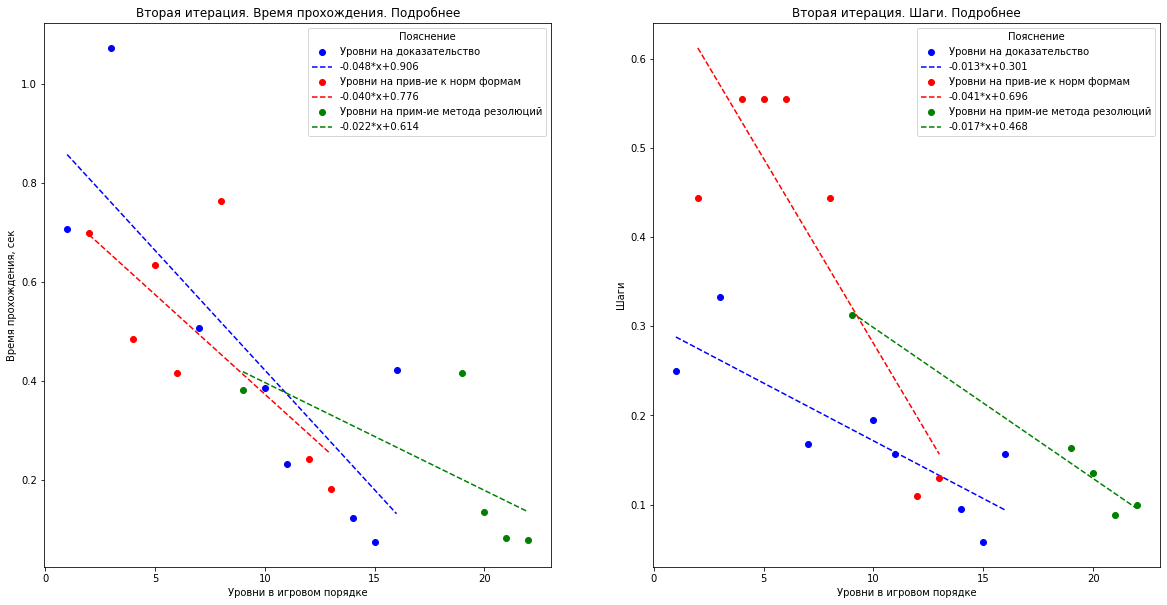

In [13]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)

plt.title("Вторая итерация. Время прохождения. Подробнее")
plt.xlabel("Уровни в игровом порядке")
plt.ylabel("Время прохождения, сек")

x = prove_levels["task_id"].to_numpy() % 1000
y = prove_levels["time_coeff"].to_numpy()
plt.plot(x, y, "bo", label="Уровни на доказательство")
k = np.polyfit(x, y, 1)
print(k)
plt.plot(x, k[0] * x + k[1], "b--", label="{:.3f}*x+{:.3f}".format(k[0], k[1]))

x = norm_form_levels["task_id"].to_numpy() % 1000
y = norm_form_levels["time_coeff"].to_numpy()
plt.plot(x, y, 'ro', label="Уровни на прив-ие к норм формам")
k = np.polyfit(x, y, 1)
print(k)
plt.plot(x, k[0] * x + k[1], "r--", label="{:.3f}*x+{:.3f}".format(k[0], k[1]))

x = resolution_levels["task_id"].to_numpy() % 1000
y = resolution_levels["time_coeff"].to_numpy()
plt.plot(x, y, 'go', label="Уровни на прим-ие метода резолюций")
k = np.polyfit(x, y, 1)
print(k)
plt.plot(x, k[0] * x + k[1], "g--", label="{:.3f}*x+{:.3f}".format(k[0], k[1]))

plt.legend(title="Пояснение")

"""~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Steps ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"""
plt.subplot(1, 2, 2)

plt.title("Вторая итерация. Шаги. Подробнее")
plt.xlabel("Уровни в игровом порядке")
plt.ylabel("Шаги")

x = prove_levels["task_id"].to_numpy() % 1000
y = prove_levels["step_coeff"].to_numpy()
plt.plot(x, y, "bo", label="Уровни на доказательство")
k = np.polyfit(x, y, 1)
print(k)
plt.plot(x, k[0] * x + k[1], "b--", label="{:.3f}*x+{:.3f}".format(k[0], k[1]))

x = norm_form_levels["task_id"].to_numpy() % 1000
y = norm_form_levels["step_coeff"].to_numpy()
plt.plot(x, y, 'ro', label="Уровни на прив-ие к норм формам")
k = np.polyfit(x, y, 1)
print(k)
plt.plot(x, k[0] * x + k[1], "r--", label="{:.3f}*x+{:.3f}".format(k[0], k[1]))

x = resolution_levels["task_id"].to_numpy() % 1000
y = resolution_levels["step_coeff"].to_numpy()
plt.plot(x, y, 'go', label="Уровни на прим-ие метода резолюций")
k = np.polyfit(x, y, 1)
print(k)
plt.plot(x, k[0] * x + k[1], "g--", label="{:.3f}*x+{:.3f}".format(k[0], k[1]))

plt.legend(title="Пояснение")

### Вывод

1. Исходя из угла наклона линии тренда, игра действительно обучает.

2. Стоит заметить, что угол наклона во второй итерации больше, а значит игра стала более эффективная!

3. Если рассматривать вторую итерацию более подробно, то можно заметить, что, исходя из углов наклона линий трендов, студентам легче дались задачи на доказательства и тяжелее на резолюцию.

## Сравнение итераций

Рассмотрим статистику по действиям пользователей в процессе игры за время двух итераций и сравним.

In [14]:
level_actions = ["place", "rule", "undo"]
start_actions = ["start"]
end_actions = ["restart", "menu", "win", "loose"]
wrong_task_ids = [0, 1023, 1024, 1025, 1026]
necessary_actions = level_actions + start_actions + end_actions

all_actions: pd.DataFrame = math_log[["user_game_identifier", "task_id", "action"]]\
    .query("user_game_identifier in @valuable_players_list and "
           "action in @necessary_actions and "
           "task_id not in @wrong_task_ids").copy()
all_actions_by_user_stat: pd.DataFrame = all_actions.groupby(["user_game_identifier", "task_id"], as_index=False)\
    .size().reset_index(name="all_actions_sum_count")
all_actions_stat: pd.DataFrame = all_actions_by_user_stat.drop(["user_game_identifier"], axis=1)\
    .groupby("task_id", as_index=False).median()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Среднее количество всех действий на каждый уровень ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(all_actions_stat)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Среднее количество всех действий на каждый уровень ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    task_id  all_actions_sum_count
0       100                   56.0
1       101                  133.0
2       102                   80.0
3       103                   24.5
4       104                   56.0
5       105                   97.0
6       106                   27.0
7       107                   23.0
8       108                   48.0
9       109                   22.0
10      110                   20.0
11      111                   15.0
12      112                   15.0
13      113                   11.5
14      114                   62.0
15      115                  130.0
16      116                   14.0
17      117                   39.5
18      118                   10.0
19      119                   21.5
20      120                   38.5
21     1001                  180.0
22     1002                   37.0
23     1003        

Посмотрим, сколько запускали каждый уровень. Будем считать, что таким образом мы получили среднее количество "игор"
в каждый уровень. Таким образом мы сможем усреднить значения из таблицы выше и получить среднее количество действий за
одну игру с каждым уровнем.

In [15]:
start_actions_by_user_stat: pd.DataFrame = all_actions.query("action in @start_actions")\
    .groupby(["user_game_identifier", "task_id"], as_index=False)\
    .size().reset_index(name="start_actions_count")
start_actions_stat: pd.DataFrame = start_actions_by_user_stat.drop(["user_game_identifier"], axis=1)\
    .groupby("task_id", as_index=False).median()
all_actions_stat["start_actions_median"] = start_actions_stat["start_actions_count"]
all_actions_stat["all_actions_each_count"] = all_actions_stat["all_actions_sum_count"] / all_actions_stat["start_actions_median"]
#print(all_actions_stat)
first_iter_all_info = all_actions_stat.loc[0:20]["all_actions_each_count"].median()
second_iter_all_info = all_actions_stat.loc[21:42]["all_actions_each_count"].median()
print("Медиана количества всевозможных действий на *первую* итерацию: {}".format(first_iter_all_info))
print("Медиана количества всевозможных действий на *вторую* итерацию: {}".format(second_iter_all_info))
print("Отношение: {}".format(second_iter_all_info / first_iter_all_info))

Медиана количества всевозможных действий на *первую* итерацию: 12.833333333333334
Медиана количества всевозможных действий на *вторую* итерацию: 22.25
Отношение: 1.7337662337662336


**Промежуточный вывод**

Количество действий на уровень в среднем увеличилось во второй итерации почти в 2 раза! А значит игра стала сложнее и требует больше взаимодействия от пользователя.

         first_iteration  second_iteration      diff
menu                 1.8          3.654762  2.030423
restart              3.0          7.556452  2.518817
win                  1.0          1.596059  1.596059


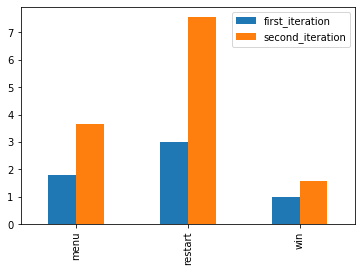

In [16]:
end_actions_by_user_stat: pd.DataFrame = all_actions.query("action in @end_actions")\
    .groupby(["user_game_identifier", "task_id", "action"], as_index=False)\
    .size().reset_index(name="actions_count")
end_actions_stat: pd.DataFrame = end_actions_by_user_stat.drop(["user_game_identifier"], axis=1)\
    .groupby(["task_id", "action"], as_index=False).mean()
#print(end_actions_stat)
first_iter = end_actions_stat.loc[0:72].drop("task_id", axis=1).groupby("action").median().drop("loose")
second_iter = end_actions_stat.loc[73:138].drop("task_id", axis=1).groupby("action").median()
summary = pd.DataFrame(index=["menu", "restart", "win"])
summary["first_iteration"] = first_iter["actions_count"]
summary["second_iteration"] = second_iter["actions_count"]
summary.plot.bar()
summary["diff"] = summary["second_iteration"] / summary["first_iteration"]
print(summary)

**Промежуточный вывод**

1. Судя по увеличению количества перезапусков и выходов в меню (более чем в 2 раза!), игра стала более сложная  
2. Судя по увеличению количества побед более чем в 1.5 раза, игра стала более мотивирующей и интересной

     task_id action  actions_count
0        100  place           24.0
1        100   rule            8.0
2        100   undo            4.0
3        101  place           84.0
4        101   rule           32.0
5        101   undo            5.0
6        102  place           43.0
7        102   rule           28.0
8        102   undo            3.0
9        103  place           14.0
10       103   rule            6.0
11       103   undo            2.5
12       104  place           30.0
13       104   rule           16.0
14       104   undo            2.0
15       105  place           48.0
16       105   rule           22.0
17       105   undo           15.0
18       106  place           15.0
19       106   rule            9.0
20       106   undo            3.0
21       107  place            9.0
22       107   rule            5.0
23       107   undo            3.5
24       108  place           25.0
25       108   rule           12.0
26       108   undo            5.0
27       109  place 

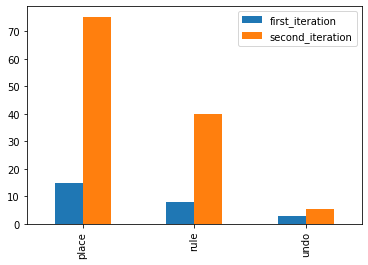

In [17]:
level_actions_by_user_stat: pd.DataFrame = all_actions.query("action in @level_actions")\
    .groupby(["user_game_identifier", "task_id", "action"], as_index=False)\
    .size().reset_index(name="actions_count")
level_actions_stat: pd.DataFrame = level_actions_by_user_stat.drop(["user_game_identifier"], axis=1)\
    .groupby(["task_id", "action"], as_index=False).median()
print(level_actions_stat)
first_iter = level_actions_stat.loc[0:62].drop("task_id", axis=1).groupby("action").median()
second_iter = level_actions_stat.loc[63:128].drop("task_id", axis=1).groupby("action").median()
summary = pd.DataFrame(index=["place", "rule", "undo"])
summary["first_iteration"] = first_iter["actions_count"]
summary["second_iteration"] = second_iter["actions_count"]
summary.plot.bar()
summary["diff"] = summary["second_iteration"] / summary["first_iteration"]
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~ Summary ~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(summary)

**Промежуточный вывод**

Во второй итерации на уровни потребовалось в 5 раз больше тыков на формулу и правила
Игроки стале чаще использовать "шаг назад" 

*Nota Bene:*
Проглядывается, что:
1. `place ~ rule * 2`  
2. `undo` ~ показатель сложности уровня?

# TODO
1. Посмотреть для каждого игрока разность между place  
  * Вообще убрать все остальные действия и просто посмотреть на place и разность
  * Посмотреть для каждого уровня (?)
  * Посмотреть для каждого уровня для каждого запуска (?)
2. undo_considering_policy?
3. Как учесть различные коэффициенты для каждого игрока?